# Bug Mask Annotation
Create mask annotations to [Hanset et al. bug crop dataset](https://zenodo.org/record/3549369#.YO2sgugzaCi) as train and validation set using conventional semgentation approaches.

In [1]:
from google.colab import drive
import os
import sys

drive.mount("/content/drive")

ModuleNotFoundError: No module named 'google'

In [3]:
import re
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import pandas as pd
import scipy
from glob import glob
import skimage
from skimage.filters import *
from tqdm import tqdm

os.chdir("..")
assert os.getcwd().split(os.path.sep)[-1] == "pg_iss"

from lib.cv2_topology_handler import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Fetch the data

In [ ]:
# !mkdir /content/tmp/
# !wget -c -O /content/tmp/file.tar https://zenodo.org/record/3549369/files/database.tar?download=1
# !tar -xvf /content/tmp/file.tar -C /content/drive/MyDrive/PG/pg_iss/data/raw/
# !mv /content/drive/MyDrive/PG/pg_iss/data/raw/database /content/drive/MyDrive/PG/pg_iss/data/raw/BugCrops/
# !find /content/drive/MyDrive/PG/pg_iss/data/raw/BugCrops -type f | wc -l

This should have created 63364 single image crops.

## Preperations

In [5]:
path = "data/raw/BugCrops/"
files = glob(os.path.join(path, "*/*.jpg"))
assert len(files) == 63364

### Select test images

In [6]:
n_examples = 10
np.random.seed(42)
test_set = np.random.choice(files, n_examples)

### Some examples

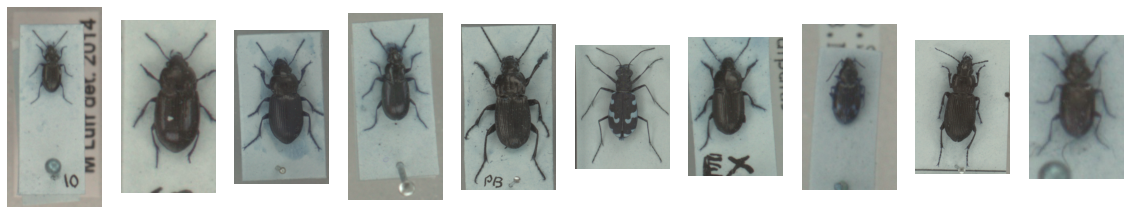

In [7]:
plt.figure(figsize=(20, 8))
for i, f in enumerate(test_set):
    ax = plt.subplot(1, n_examples, i + 1)
    img = cv2.imread(f, 1)
    plt.imshow(img,)
    ax.axis("off")

### Check file naming conventions

In [8]:
s = [re.sub(r"[\d]*\\", "", x) for x in files]
assert len(set(s)) == len(set(files))
print(f"{len(files)} images and {len(s)} unique names")

63364 images and 63364 unique names


<AxesSubplot:>

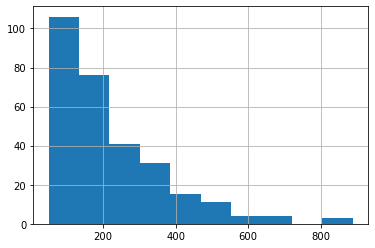

In [10]:
df = pd.DataFrame(
    [x.split(os.path.sep) for x in files], columns=(" ", " ", " ", "species", "img")
).iloc[:, 1:]
df.species.value_counts().hist()

## Thresholding based segmentation

### Segmentations Pipeline

The segmentation is carried out using the following steps:


1.   Load image and convert to grayscale    
2.   Segment the legs


*   Create a mask reflecting the rough brightness distribution and subtract the original image from this mask. This enhances the signal of parts that are far away from the body (e.g. legs) wheareas lowers the signal of the shadows close to the body.
*   Threshold (Otsu) this map in order to get the legs


3.   Segment the body

*    Blur the image via an average filter and threshold at the edges of the body
*    Fill holes inside (body is assumed to be closed)

4.   Combine
5.   Connect seperated parts by morphological closing



In [11]:
idx = 42423  # demonstrate object selection
idx = 42442  # demonstrate body closing

ValueError: too many values to unpack (expected 2)

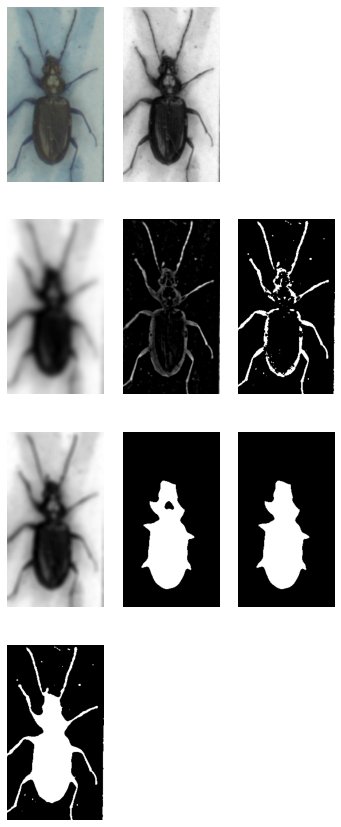

In [12]:
# plt.figure(figsize=(40,60))
plt.figure(figsize=(10, 15))
nrow, ncol = (4, 5)

# load image
img = cv2.imread(files[idx], 1)
ax = plt.subplot(nrow, ncol, 1)
ax.axis("off")
plt.imshow(img)

gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ax = plt.subplot(nrow, ncol, 2)
ax.axis("off")
plt.imshow(gray, cmap="gray")

# legs
legs = gray.copy()
legs_background = scipy.ndimage.gaussian_filter(legs, sigma=round(img.shape[1] / 40))
ax = plt.subplot(nrow, ncol, ncol * 1 + 1)
ax.axis("off")
plt.imshow(legs_background, cmap="gray")

legs = cv2.subtract(legs_background, legs)
ax = plt.subplot(nrow, ncol, ncol * 1 + 2)
ax.axis("off")
plt.imshow(legs, cmap="gray")

legs = (legs > threshold_otsu(legs)).astype(np.uint8)
ax = plt.subplot(nrow, ncol, ncol * 1 + 3)
ax.axis("off")
plt.imshow(legs, cmap="gray")

# body
body = cv2.blur(gray, (round(img.shape[1] / 20),) * 2)
ax = plt.subplot(nrow, ncol, ncol * 2 + 1)
ax.axis("off")
plt.imshow(body, cmap="gray")

body = body < threshold_minimum(body)
ax = plt.subplot(nrow, ncol, ncol * 2 + 2)
ax.axis("off")
plt.imshow(body, cmap="gray")

body = scipy.ndimage.binary_fill_holes(body).astype(np.uint8)
ax = plt.subplot(nrow, ncol, ncol * 2 + 3)
ax.axis("off")
plt.imshow(body, cmap="gray")

# combine
close_size = max(7, img.shape[1] // 80)
mask = cv2.bitwise_or(body, legs)
mask = cv2.morphologyEx(
    mask, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
)
mask = mask.astype(np.uint8)
ax = plt.subplot(nrow, ncol, ncol * 3 + 1)
ax.axis("off")
plt.imshow(mask, cmap="gray")

# find biggest structure and handle topology
cont, hir = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
areas = np.array([cv2.contourArea(cnt) for cnt in cont])
idx = areas.argmax()
joint = handle_contour_topology(cont, hir, idx)

mask = np.zeros(img.shape[:2], dtype=np.uint8)
cv2.drawContours(mask, [joint], -1, (255), -1)
ax = plt.subplot(nrow, ncol, ncol * 3 + 2)
ax.axis("off")
plt.imshow(mask, cmap="gray")


cv2.drawContours(img, [joint], -1, (0, 255, 0), 1)
ax = plt.subplot(nrow, ncol, ncol * 3 + 3)
ax.axis("off")
plt.imshow(img)

### Some examplary results

In [ ]:
plt.figure(figsize=(25, 7))
for i, f in enumerate(test_set):
    ax = plt.subplot(3, n_examples, i + 1)
    ax.axis("off")
    img = cv2.imread(f, 1)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # legs
    legs = gray.copy()
    legs_background = scipy.ndimage.gaussian_filter(
        legs, sigma=round(img.shape[1] / 40)
    )
    legs = cv2.subtract(legs_background, legs)
    legs = (legs > threshold_otsu(legs)).astype(np.uint8)

    # body
    body = cv2.blur(gray, (round(img.shape[1] / 20),) * 2)
    body = body < threshold_minimum(body)
    body = scipy.ndimage.binary_fill_holes(body).astype(np.uint8)

    # whole bug
    close_size = max(7, img.shape[1] // 80)
    mask = cv2.bitwise_or(body, legs)
    mask = cv2.morphologyEx(
        mask, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7))
    )
    mask = mask.astype(np.uint8)

    cont, hir = cv2.findContours(mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    areas = np.array([cv2.contourArea(cnt) for cnt in cont])
    idx = areas.argmax()

    joint = handle_contour_topology(cont, hir, idx)
    cv2.drawContours(img, [joint], -1, (0, 255, 0), 2)
    plt.imshow(img, cmap="gray")
    ax = plt.subplot(3, n_examples, len(test_set) + i + 1)
    plt.imshow(mask, cmap="gray")
    ax.axis("off")
    mask = np.zeros(img.shape[:2], dtype=np.uint8)
    cv2.drawContours(mask, [joint], -1, (255), -1)
    ax = plt.subplot(3, n_examples, len(test_set) * 2 + i + 1)
    plt.imshow(mask, cmap="gray")
    ax.axis("off")

### Run segmentation

This chunks runs the segmentation on the specified directory and saves a visualization of the created masks inside the defined output dir. 
It will segment 11 images for each dir (each species) in the hope that a least two of them are fine.
You will then need to manually deleted inproperly masked images and copy the remaining images to the curated mask dir and count if all species have at least 2 masks, else repeat so long there not enough masks available.

In [28]:
output_dir = "data/raw/bug_auto_seg"
curated_masks = "data/raw/bug_masks"

In [29]:
avail_spec = pd.DataFrame([x.split("-")[0] for x in os.listdir(curated_masks)])[
    0
].value_counts()
avail_spec.head()

1035542    14
9364935    13
4480502    12
4471269    11
5755044    11
Name: 0, dtype: int64

In [30]:
sum(avail_spec > 2)

291

In [31]:
from lib.preprocessing import segment_bugs_from_crops

In [27]:
for spec in tqdm(os.listdir(path)):
    for i, file in enumerate(
        np.random.permutation(os.listdir(os.path.join(path, spec)))
    ):
        try:
            file_name = os.path.join(
                output_dir, spec + "-" + file.replace(".jpg", ".png")
            )
            if (
                i > 10 or spec in avail_spec and avail_spec[spec] > 2
            ):  # skip if enough maked instances are available
                continue
            img = cv2.imread(os.path.join(path, spec, file), 1)
            mask = segment_bugs_from_crops(img)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGRA)  # output visualization
            img[:, :, 3] = mask / 2 + 128
            img[:, :, 1] = cv2.add(img[:, :, 1], (255 - mask) // 4)
            img[:, :, 2] = cv2.add(img[:, :, 2], (mask // 4))
            cv2.imwrite(file_name, img)

        #             cv2.imwrite(file_name.replace(".png", "_mask.png"), mask) # save mask for manual editing
        except RuntimeError:
            continue

100%|███████████████████████████████████████████████████████████████████████████████| 291/291 [00:02<00:00, 131.70it/s]


In [19]:
for spec in os.listdir(path):
    for i, file in enumerate(
        np.random.permutation(os.listdir(os.path.join(path, spec)))
    ):
        try:
            file_name = os.path.join(
                output_dir, spec + "-" + file.replace(".jpg", ".png")
            )
            if (
                i > 10 or spec in avail_spec and avail_spec[spec] > 2
            ):  # skip if enough maked instances are available
                continue
            img = cv2.imread(os.path.join(path, spec, file), 1)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # legs
            legs = gray.copy()
            legs_background = scipy.ndimage.gaussian_filter(
                legs, sigma=round(img.shape[1] / 40)
            )
            legs = cv2.subtract(legs_background, legs)
            legs = (legs > threshold_otsu(legs)).astype(np.uint8)

            # body
            body = cv2.blur(gray, (round(img.shape[1] / 20),) * 2)
            body = body < threshold_minimum(body)
            body = scipy.ndimage.binary_fill_holes(body).astype(np.uint8)

            # whole bug
            close_size = max(7, img.shape[1] // 80)
            mask = cv2.bitwise_or(body, legs)
            mask = cv2.morphologyEx(
                mask,
                cv2.MORPH_CLOSE,
                cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (7, 7)),
            )
            mask = mask.astype(np.uint8)

            _, cont, hir = cv2.findContours(
                mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
            )
            areas = np.array([cv2.contourArea(cnt) for cnt in cont])
            idx = areas.argmax()

            mask = np.zeros(img.shape[:2], dtype=np.uint8)
            cv2.drawContours(
                image=mask,
                contours=cont,
                contourIdx=idx,
                color=(255),
                thickness=-1,
                hierarchy=hir,
                maxLevel=1,
            )

            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGRA)  # output visualization
            img[:, :, 3] = mask / 2 + 128
            img[:, :, 1] = cv2.add(img[:, :, 1], (255 - mask) // 4)
            img[:, :, 2] = cv2.add(img[:, :, 2], (mask // 4))
            cv2.imwrite(file_name, img)

        #             cv2.imwrite(file_name.replace(".png", "_mask.png"), mask) # save mask for manual editing
        except RuntimeError:
            continue

### Retrieve masks from visulization

Restore original image and save as RGBA (where the alpha channel is the mask) and perform train - validation split. Here, for each species one instance is used for validation.

In [ ]:
dst = {"train": "data/mask_iter/1st_run/train/", "test": "data/mask_iter/1st_run/test/"}
[os.makedirs(x, exist_ok=True) for x in dst.values()]

In [ ]:
avail_spec = pd.DataFrame([x.split("-")[0] for x in os.listdir(curated_masks)])[
    0
].value_counts()
assert np.all(avail_spec > 2)

np.random.seed(42)

for f in tqdm(np.random.permutation(os.listdir(curated_masks))):
    spec, file_name = f.split("-")
    set_key = "train" if avail_spec[spec] > 1 else "test"
    avail_spec[spec] -= 1

    raw_image_path = os.path.join(path, spec, file_name.replace(".png", ".jpg"))
    img = cv2.imread(raw_image_path, 1).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2RGBA)
    mask = cv2.imread(os.path.join(curated_masks, f), cv2.IMREAD_UNCHANGED)
    img[:, :, 3] = (mask[:, :, 3] > 128) * 255
    cv2.imwrite(os.path.join(dst[set_key], file_name), img)